# Actual stuff

Launch two terminals from the main tree.

In [1]:
# get some basic os functions
import os
import glob
# import our parallel processing framework
import dask
import dask.multiprocessing
from dask.diagnostics import ProgressBar
import distributed
from distributed.diagnostics import progress
# numpy and plotting
import numpy as np
from itertools import accumulate
from operator import matmul
%matplotlib inline
import matplotlib.pyplot as plt
# image reading and writing
from skimage.external import tifffile as tif
#
import seaborn as sns
# load our actual registration functions
from imreg_dph import *
# monkey patch in numpy's fft, pyfftw doesn't play nice with the cluster
import imreg_dph
imreg_dph.fft2 = np.fft.fft2
imreg_dph.ifft2 = np.fft.ifft2
imreg_dph.fftshift = np.fft.fftshift

if running on the cluster we need to start our scheduler:

    dask-scheduler --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

this should be done on the same computer that's running this notebook (not windows, use login1 or login2 or
 a qlogin interactive session on the cluster)
 
You can now open up a status window [http://[all ip addresses on host]:8787](http://localhost:8787)

In [2]:
# if running on cluster we need to start our workers
!qsub -pe batch 32 -t 1-32 -b y -j y -o ./dask-log.log -cwd -V dask-worker --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

Your job-array 20274135.1-32:1 ("dask-worker") has been submitted


In [75]:
# if running on the cluster we need to attached to the scheduler
client = distributed.Client(scheduler_file="/groups/betzig/home/hoffmand/dask-scheduler.json")

In [3]:
# change this if needed
paths = sorted(glob.iglob("/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_*_InLens/*.tif"))
len(paths)

23749

In [4]:
# generate a list of pairs to register together
pairs = [(paths[i], paths[i + 1]) for i in range(len(paths) - 1)]
pairs[:4]

[('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000030_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000133_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000133_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000237_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000237_0-0-0_InLens.tif',
  '/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D04_InLens/NVision40-3802_17-03-31_000340_0-0-0_InLens.tif'),
 ('/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Cryo_20170220_M03D31-M04D

In [5]:
def load_and_register(path0, path1, method=register_translation, *args, **kwargs):
    """Load two images defined by path0 and path1 (assumed to be tif) and register with meth
    
    Parameters
    ----------
    path0 : URI to data0
    path1 : URI to data1
    method : callable
        the registration algortithm
    args : args passed to meth
    kwargs : kwargs passed to meth
    
    Returns
    -------
    af : AffineTransformation
        The affine transformation that registers path1 to path0
    """
    data0 = tif.imread(path0)
    data1 = tif.imread(path1)
    
    return method(data0, data1, *args, **kwargs)

In [7]:
# test the registration and time it
%time af = load_and_register(*pairs[0], register_translation)
print(af)

CPU times: user 14.6 s, sys: 1.61 s, total: 16.3 s
Wall time: 6.13 s
<AffineTransform: translation = [-1.87 -3.35], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [8]:
to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_translation) for path0, path1 in pairs])
sub_res = client.compute(to_compute)
progress(sub_res)

NameError: name 'progress' is not defined

In [10]:
progress(sub_res)

In [8]:
# Now we can propagate the transformations throughout the whole stack.
def plot_af_accum(results):
    results2 = list(accumulate(results, matmul))

    # and plot the results
    fig, axs = plt.subplots(2,2, figsize=(9,9), sharex=True)
    axs = axs.flatten()
    axs[0].plot(np.array([result.translation for result in results2]))
    axs[3].plot(np.rad2deg(np.array([result.rotation for result in results2])))
    axs[1].plot((np.array([result.scale for result in results2])))
    axs[2].plot(np.rad2deg(np.array([result.shear for result in results2])))

    axs[0].set_title("translation")
    axs[3].set_title("rotation")
    axs[1].set_title("scale")
    axs[2].set_title("shear")

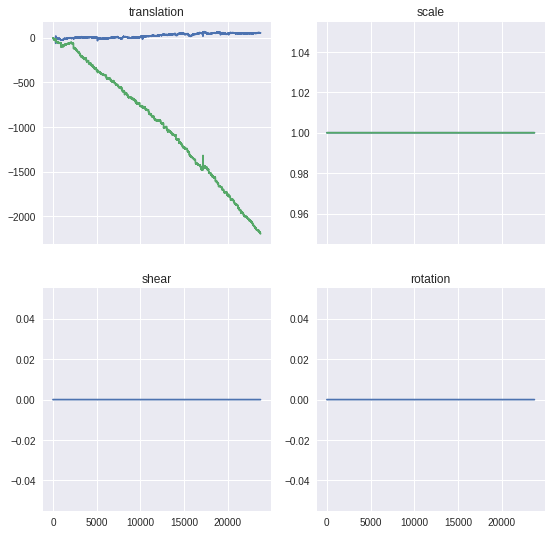

In [15]:
results_register_translation = sub_res.result()
plot_af_accum(results_register_translation)

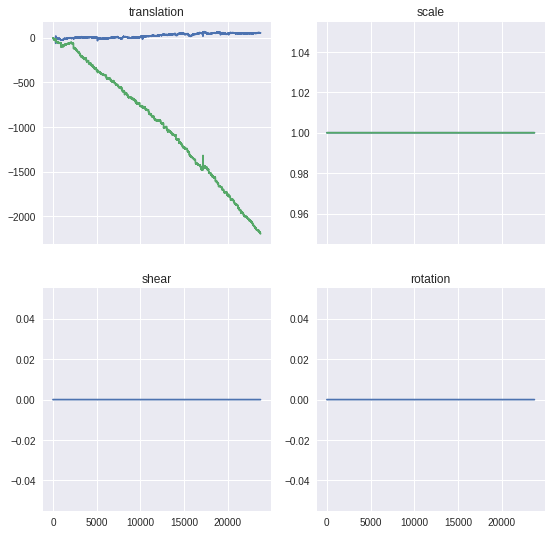

In [9]:
results_register_translation = [AffineTransform(d) for d in np.load("results_register_translation.npy")]
plot_af_accum(results_register_translation)

In [45]:
# we can save the results in a numpy array
np.save("results_register_translation.npy", np.array([result.params for result in results_register_translation]))

In [104]:
results_register_translation_accum = list(accumulate([AffineTransform(np.eye(3))] + results_register_translation, matmul))

In [103]:
def load_transform_avg(paths, afs, shape, filename):
    data = np.array([tif.imread(path) for path in paths])
    data_warp = np.array([cv_warp(im, af, shape) for im, af in zip(data, afs)])
    tif.imsave(filename, data_warp.mean(0).astype(data.dtype))

In [105]:
paths_arr = np.array(paths)
afs_array = np.array(results_register_translation_accum)

In [106]:
paths_arr.shape

(23749,)

In [107]:
afs_array.shape

(23749,)

In [108]:
os.mkdir("/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Test Align")

In [110]:
mydir = "/groups/hess/hesslab/Cryo_data/EM_data/17-7_20170220_CS2_Cell6/Test Align/"

In [127]:
to_compute = dask.delayed([dask.delayed(load_transform_avg, pure=True)(p, a, (5000, 11000), mydir + "{:05d}.tif".format(i))
                          for i, (p, a) in enumerate(zip(paths_arr[:-1].reshape(-1, 4), afs_array[:-1].reshape(-1, 4)))
                          ])

In [128]:
sub_res = client.compute(to_compute)
progress(sub_res)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [76]:
import dask.array as da
from dask import delayed

imread = delayed(tif.imread, pure=True)  # Lazy version of imread

sample = tif.imread(paths[0])

lazy_values = [imread(path) for path in paths]     # Lazily evaluate imread on each url

raw_arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]

raw_stack = da.stack(raw_arrays, axis=0)                # Stack all small Dask arrays into one

In [77]:
raw_stack

dask.array<stack, shape=(23749, 2250, 10000), dtype=uint8, chunksize=(1, 2250, 10000)>

In [78]:
raw_stack = raw_stack.rechunk((750, 2250, 10000))

In [79]:
raw_stack

dask.array<rechunk-merge, shape=(23749, 2250, 10000), dtype=uint8, chunksize=(750, 2250, 10000)>

In [80]:
raw_stack[0]

dask.array<getitem, shape=(2250, 10000), dtype=uint8, chunksize=(2250, 10000)>

In [86]:
raw_stack = client.persist(raw_stack)

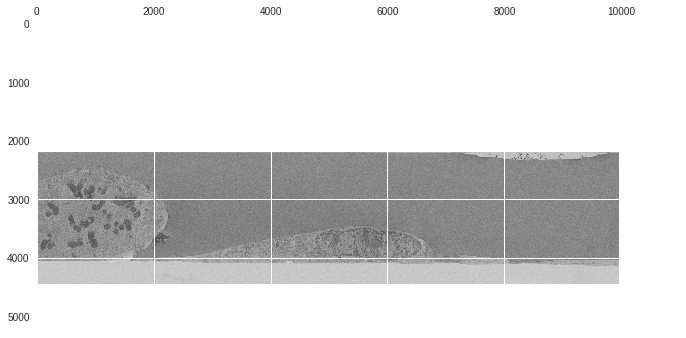

In [82]:
sample_warp = cv_warp(sample, results_register_translation_accum[-1], (5250, 11000))
plt.matshow(sample_warp)

In [83]:
lazy_warp = dask.delayed(cv_warp, pure=True)

In [87]:
%timeit junk = lazy_warp(raw_stack[-1], results_register_translation_accum[-1])

1000 loops, best of 3: 368 µs per loop


In [88]:
lazy_warp_values = ([lazy_warp(d, af, sample_warp.shape) for d, af in zip(raw_stack, results_register_translation_accum)])

In [89]:
transformed_arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample_warp.dtype,   # for every lazy value
                          shape=sample_warp.shape)
          for lazy_value in lazy_warp_values]

In [90]:
transformed_stack = da.stack(transformed_arrays, axis=0)

In [91]:
transformed_stack

dask.array<stack, shape=(23749, 5250, 11000), dtype=uint8, chunksize=(1, 5250, 11000)>

In [92]:
transformed_stack = transformed_stack.rechunk((750, 5250, 11000))

In [93]:
transformed_stack

dask.array<rechunk-merge, shape=(23749, 5250, 11000), dtype=uint8, chunksize=(750, 5250, 11000)>

In [94]:
transformed_stack = client.persist(transformed_stack)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP 'tcp://10.36.105.23:8786'>
tornado.application - ERROR - Exception in callback None
Traceback (most recent call last):
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 886, in start
    fd_obj, handler_func = self._handlers[fd]
KeyError: 73


In [95]:
23749 % 4

1

In [96]:
transformed_stack_zbin4 = transformed_stack[:-1].reshape(-1, 4, 5250, 11000)

In [97]:
transformed_stack_zbin4 = client.persist(transformed_stack_zbin4)

In [98]:
transformed_stack_zbin4 = transformed_stack_zbin4.astype(np.uint8)

In [99]:
transformed_stack_zbin4 = client.persist(transformed_stack_zbin4)

In [100]:
transformed_stack_zbin4 = transformed_stack_zbin4.mean(axis=1)

In [101]:
transformed_stack_zbin4 = client.persist(transformed_stack_zbin4)

In [102]:
plt.matshow(transformed_stack_zbin4[0].compute())

distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.utils - ERROR - ('getitem-6adf353735857b20c099c7983d3cb479', 0, 0)
Traceback (most recent call last):
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 929, in _gather
    st = self.futures[key]
KeyError: "('getitem-6adf353735857b20c099c7983d3cb479', 0, 0)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 193, in f
    result[0] = yield gen.maybe_future(func(*args, **kwargs))
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/groups/betzig/home/hoffmand/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 237, in re

CancelledError: ('getitem-6adf353735857b20c099c7983d3cb479', 0, 0)

# Break

In [60]:
# test the registration and time it
%time af = load_and_register(*pairs[0], translation)
print(af)

CPU times: user 5.22 s, sys: 1.24 s, total: 6.46 s
Wall time: 6.45 s
<AffineTransform: translation = [-1.93 -3.64], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [ ]:
to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, translation)
                           for path0, path1 in pairs])
%time results_translation = to_compute.compute()
plot_af_accum(results_translation)

In [71]:
# we can save the results in a numpy array
np.save("results_translation.npy", np.array([result.params for result in results_translation]))

In [66]:
# test the registration and time it
%time af = load_and_register(*pairs[0], translation)
print(af)

CPU times: user 6.15 s, sys: 14.6 s, total: 20.7 s
Wall time: 20.9 s
<AffineTransform: translation = [-1.93 -3.64], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [6]:
import warnings

In [11]:
imreg_dph.fft2 = np.fft.fft2
imreg_dph.ifft2 = np.fft.ifft2
imreg_dph.fftshift = np.fft.fftshift

In [12]:
imreg_dph.fft2

<function numpy.fft.fftpack.fft2>

In [41]:
to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, similarity) for path0, path1 in pairs[:5000]])
sub_res = client.compute(to_compute)
progress(sub_res)

In [ ]:
results_similarity = to_compute.compute()

In [19]:
import pyfftw
pyfftw.interfaces.cache.enable()

In [34]:
def fft_random():
    f0 = pyfftw.interfaces.numpy_fft.fftn(np.empty((10000, 2250)))
    f1 = pyfftw.interfaces.numpy_fft.fftn(np.empty((10000, 2250)))
    eps = np.finfo(f0.dtype).eps
    f3 = f0 * f1.conjugate() / (abs(f0) * abs(f1) + eps)

In [35]:
%timeit fft_random()

1 loop, best of 3: 3.14 s per loop


In [9]:
from distributed.diagnostics import progress

In [46]:
%timeit load_and_register(*pairs[0], similarity)

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)
/groups/betzig/home/hoffmand/Pytho

1 loop, best of 3: 28.9 s per loop


In [45]:
to_compute = dask.delayed([dask.delayed(load_and_register)(*pairs[0], similarity) for i in range(20)])
out = client.compute(to_compute)
progress(out)

In [47]:
with ProgressBar():
    to_compute = dask.delayed([dask.delayed(load_and_register)(*pairs[0], similarity) for i in range(20)])
    to_compute.compute(get=dask.multiprocessing.get);

[                                        ] | 0% Completed | 41.5s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 42.2s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 42.3s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 42.6s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 42.9s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 43.0s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 43.2s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 43.8s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 43.9s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 44.2s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 44.7s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 45.4s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 45.9s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[                                        ] | 0% Completed | 46.1s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[##############################          ] | 76% Completed |  1min 23.1s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[##############################          ] | 76% Completed |  1min 23.6s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[##############################          ] | 76% Completed |  1min 23.9s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[##############################          ] | 76% Completed |  1min 24.1s

/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:176: RankWarning: Polyfit may be poorly conditioned
  xfit = np.polyfit(x, my_pat_fft_subx, 2)
/groups/betzig/home/hoffmand/PythonCode/Python Codes/imreg_dph.py:177: RankWarning: Polyfit may be poorly conditioned
  yfit = np.polyfit(x, my_pat_fft_suby, 2)


[########################################] | 100% Completed |  1min 31.7s


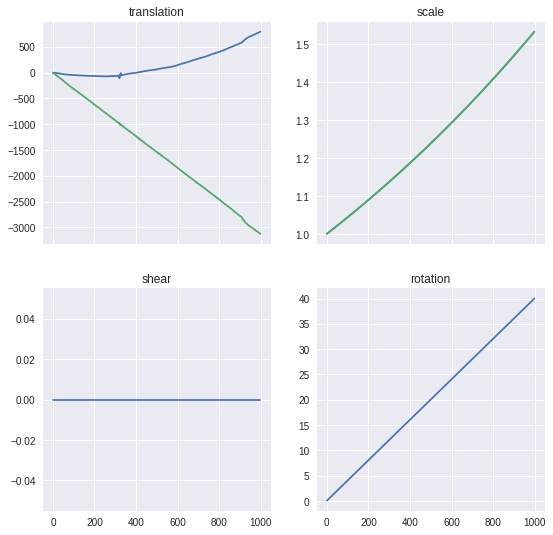

In [8]:
plot_af_accum(results_similarity)

In [39]:
# test the registration and time it
%time af = load_and_register(*pairs[0], register_ECC, warp_mode="euclidean")
print(af)

CPU times: user 1min 27s, sys: 2.9 s, total: 1min 30s
Wall time: 14.1 s
<AffineTransform: translation = [-1.85 -3.66], rotation =0.00, scale = [ 1.  1.], shear = 0.00>


In [ ]:
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC, warp_mode="translation") for path0, path1 in pairs])
%time results_ecc_trans = to_compute.compute()

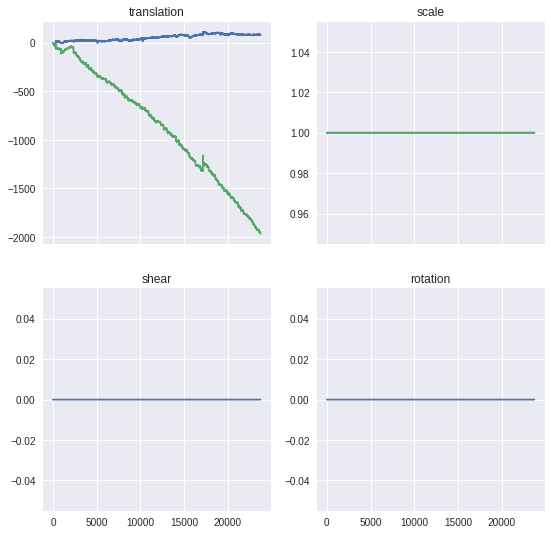

In [52]:
plot_af_accum(results_ecc_trans)

In [46]:
# we can save the results in a numpy array
np.save("results_ecc_trans.npy", np.array([result.params for result in results_ecc_trans]))

In [ ]:
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC, warp_mode="euclidean") for path0, path1 in pairs])
%time results_ecc_euc = to_compute.compute()

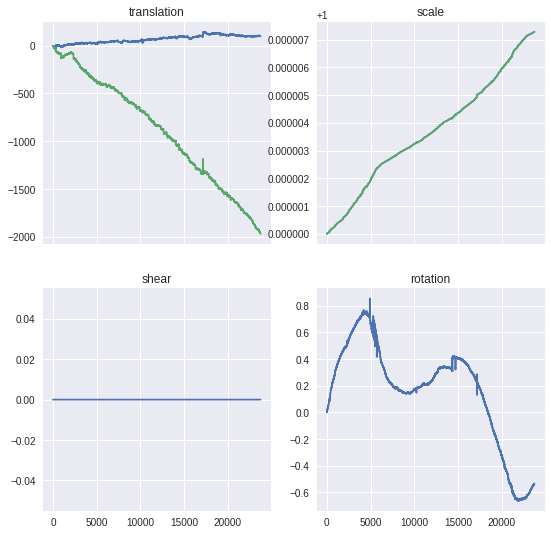

In [53]:
plot_af_accum(results_ecc_euc)

In [47]:
# we can save the results in a numpy array
np.save("results_ecc_euc.npy", np.array([result.params for result in results_ecc_euc]))

In [ ]:
%time to_compute = dask.delayed([dask.delayed(load_and_register, pure=True)(path0, path1, register_ECC, warp_mode="affine") for path0, path1 in pairs])
%time results_ecc_affine = to_compute.compute()

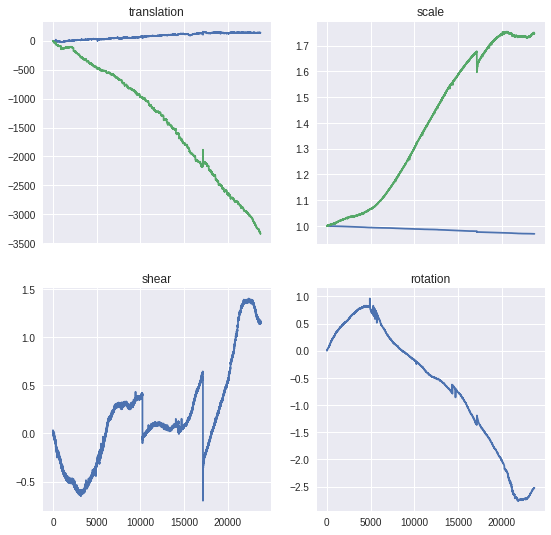

In [54]:
plot_af_accum(results_ecc_affine)

In [48]:
# we can save the results in a numpy array
np.save("results_ecc_affine.npy", np.array([result.params for result in results_ecc_affine]))

In [73]:
!qdel 19627818

hoffmand has registered the job-array task 19627818.1 for deletion
hoffmand has registered the job-array task 19627818.2 for deletion
hoffmand has registered the job-array task 19627818.3 for deletion
hoffmand has registered the job-array task 19627818.4 for deletion
hoffmand has registered the job-array task 19627818.5 for deletion
hoffmand has registered the job-array task 19627818.6 for deletion
hoffmand has registered the job-array task 19627818.7 for deletion
hoffmand has registered the job-array task 19627818.8 for deletion
hoffmand has registered the job-array task 19627818.9 for deletion
hoffmand has registered the job-array task 19627818.10 for deletion
hoffmand has registered the job-array task 19627818.12 for deletion
hoffmand has registered the job-array task 19627818.13 for deletion
hoffmand has registered the job-array task 19627818.14 for deletion
hoffmand has registered the job-array task 19627818.15 for deletion
hoffmand has registered the job-array task 19627818.16 fo

In [74]:
pwd

'/groups/betzig/home/hoffmand/PythonCode/Python Codes'

- apply transforms
- materialization
- apply and bin and materialize